## AutoCat Demo

Simple demo for using AutoCat.

Using the car price dataset: https://www.kaggle.com/aleksandrglotov/car-prices-poland

First, importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

Load "Car Prices" dataset, clean the data and prepare it (using `CarPrices` data prep class).

Pipeline description:
   - Drop redundant columns
   - Drop redundant province ("(")
   - Drop price outliers
   - Return prices in log scale

In [117]:
from evaluate.data_prep.car_prices import CarPrices

data = pd.read_csv('./evaluate/datasets/Car_Prices_Poland_Kaggle.csv')
X, Y = CarPrices().transform(data)


X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2)
X_train

,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province
81638,chevrolet,camaro,NaN,2016,57000,6162,Gasoline,Gorlice,Małopolskie
37183,volkswagen,golf,gen-vi-2008-2013,2011,89500,1390,Gasoline,Przemyśl,Podkarpackie
41248,volkswagen,passat,gen-b8-2014,2019,55869,1968,Diesel,Łódź,Łódzkie
93280,hyundai,tucson,gen-iii-2015-2020,2017,80806,1591,Gasoline,Warszawa,Mazowieckie
78255,skoda,octavia,gen-iii-2013,2019,91955,1500,Gasoline,Kowale,Pomorskie
...,...,...,...,...,...,...,...,...,...
17633,audi,a5,gen-8t-2007-2016,2008,148000,1798,Gasoline,Budzyń,Wielkopolskie
79574,skoda,superb,gen-ii-2008,2014,162090,1968,Diesel,Rybnik,Śląskie
94888,kia,ceed,gen-i-2006-2012,2009,71000,1396,Gasoline,Chojna,Zachodniopomorskie
13591,audi,a3,gen-8p-2003-2012,2006,222300,1984,Gasoline,Rydułtowy,Śląskie


First, embed using random integer labels for each class (using `NaiveCategories` transformer).
Train a Random Forest Regressor and measure the baseline performance

In [118]:
from auto_cat.cat_discover import CatDiscover
from auto_cat.transformers.naive_cat import NaiveCategories


categorical_columns = CatDiscover().discover_categories(X_train)
naive_transformer = NaiveCategories()
X_train_naive = naive_transformer.fit_transform(X_train, categorical_columns)
X_test_naive = naive_transformer.transform(X_test)

model = RandomForestRegressor(n_estimators=80, max_depth=10).fit(X_train_naive, np.log(Y_train))

naive_test_predictions = model.predict(X_test_naive)
print('r2', model.score(X_test_naive, np.log(Y_test)))
print('mae', sklearn.metrics.mean_absolute_error(np.log(Y_test), naive_test_predictions))

r2 0.9268008861120894
mae 0.016809034731774437


Next, embed using AutoCat.
Again, train a Random Forest Regressor and measure the new performance.

In [128]:
from auto_cat.auto_cat import AutoCat

autocat = AutoCat()
X_train_auto = autocat.fit_transform(X_train, np.log(Y_train))
X_test_auto = autocat.transform(X_test)

model = RandomForestRegressor(n_estimators=80, max_depth=10).fit(X_train_auto, np.log(Y_train))

autocat_test_predictions = model.predict(X_test_auto)
print('r2', model.score(X_test_auto, np.log(Y_test)))
print('mae', sklearn.metrics.mean_absolute_error(np.log(Y_test), autocat_test_predictions))

r2 0.9384184995698993
mae 0.015324706221795537


Plotting the absolute errors of the naive embedding versus the AutoCat embedding.
Note that AutoCat makes significantly smaller errors.

Text(0.5, 0, 'Absolute Log Err')

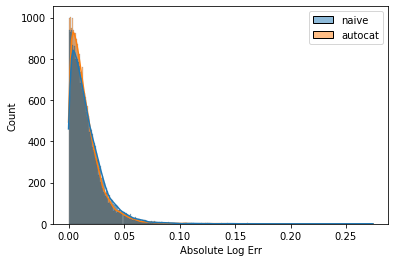

In [129]:
import seaborn as sns

sns.histplot({'naive': abs(naive_test_predictions - np.log(Y_test)),
              'autocat': abs(autocat_test_predictions - np.log(Y_test))}, kde=True,
             )
plt.xlabel('Absolute Log Err')